# A hitchhiker's guide to the world
---
### Context
In the paper, "Friendship and mobility : User movement in Location-Based Social Networks", the authors answered one important question : what influence do friends have on movements ?<br>
But what if you don't have friends in the first place and just want to blend in ? Imagine : You just arrived in a new country. You don't know how to behave with the locals and what to expect. How friendly are people ? How often is it socially acceptable to meet ? Where should you meet ? Where and when should you go on holidays ? <br>
In this Notebook, we will attempt to answer some of these questions for multiple countries.

---
### The data
“Global-scale Check-in Dataset with User Social Networks” from two research projects at this address (project 5 by Dingqi Yang): ( https://sites.google.com/site/yangdingqi/home/foursquare-dataset#h.p_7rmPjnwFGIx9). The dataset is coming from Foursquare and it contains the information of 22,809,624 checkins by 114,324 users, 607,333 friendship links and 3,820,891 POIs. It contains a set of worldwide check-ins with country flags taken over about two years and two snapshots of the corresponding user social network before (in Mar. 2012) and after (in May 2014) the check-in data collection period. <br>
In order to work with this dataset, we broke it down in smaller datasets, based on countries. In order to learn more on how we broke our dataset down, please consult the scripts "createSubDataset.ipynb" and "preprocess.ipynb".

---
### Structure of this notebook
In every subpart of this notebook, we will try to answer a different question. You will find the index of all questions here : 

- Step 1 : How many friends do natives have ?
    - Subpart 1 : Finding the nationality of users.
    - Subpart 2 : Computing number of friends.
- Step 2 : Behaving like Natives
---
### Note :
In the following notebook, all the calculations are done on one database, because they all have the same structure. When it come to the data story, we will extract information from all datasets.

In [1]:
import pandas as pd
from zipfile import ZipFile
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn

### Step 1 : How many friends do native users have ?

We want to measure how sociable natives are. In order to do so, we look at how many friends they have.

### Subpart 1 : Finding nationalities
---

We open a dataset (example : the check-ins that took place in the US in 2013). However, we don't know if all the people of this dataset are American or foreigner on vacation. Since we want to study the behaviour of the locals, we need a criterion to distinguish natives from foreigners.
- Idea 1 : We choose that a person is considered a native if he checks in more than five times in the country.
- Idea 2 : A person is considered a foreigner if he never checks in a home.

#### Idea 1

In [2]:
data_file = ZipFile('../data.zip')
df_US = pd.read_csv(data_file.open('data/1_US_2013_merge_data.csv'))

In [3]:
df_US

,zone_id,person_id,time_checkin,year,Lat,lon,building,country
0,3fd66200f964a52000e71ee3,319827,2013-01-13 00:49:25+00:00,2013,40.733596,-74.003139,Jazz Club,US
1,3fd66200f964a52000e71ee3,496140,2013-01-13 01:12:49+00:00,2013,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e71ee3,288077,2013-02-16 02:29:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
3,3fd66200f964a52000e71ee3,191931,2013-02-17 03:50:53+00:00,2013,40.733596,-74.003139,Jazz Club,US
4,3fd66200f964a52000e71ee3,1402791,2013-02-19 03:48:11+00:00,2013,40.733596,-74.003139,Jazz Club,US
...,...,...,...,...,...,...,...,...
1187592,52b6450811d248b7b0610626,1243714,2013-12-22 01:50:10+00:00,2013,33.873249,-118.387099,Home (private),US
1187593,52b65856498e252aade808b5,120150,2013-12-22 03:12:02+00:00,2013,39.281602,-76.593760,Lounge,US
1187594,52b66bde498e5705ff1ef091,212157,2013-12-22 04:48:06+00:00,2013,33.546776,-117.131694,Other Great Outdoors,US
1187595,52b67f4e498e403b8cccbe27,133864,2013-12-22 06:24:48+00:00,2013,42.331624,-83.066572,Dive Bar,US


In [4]:
US_participants = df_US.groupby(by = "person_id").agg("count")
US_natives =  US_participants[US_participants["zone_id"] >= 10]
US_foreign = US_participants[US_participants["zone_id"] < 10]
US_natives["zone_id"]

person_id
19         146
54          40
58          73
120         56
178         91
          ... 
2166978     26
2168296    137
2169991     27
2174127     92
2181131    116
Name: zone_id, Length: 15115, dtype: int64

In [5]:
df_US_foreign = df_US[df_US["person_id"].isin(US_foreign.index.tolist())]
df_US_natives = df_US[df_US["person_id"].isin(US_natives.index.tolist())]
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(US_natives.shape[0]))
print('Out of all our users, {}% have low checkins.'.format(round((1-US_natives.shape[0]/US_participants.shape[0])*100)))

Our initial dataset had 20495 users.
Out of them, 15115 are considered natives.
Out of all our users, 26% have low checkins.


Getting rid of users can seem a bit dangerous because we lose data. However, since we get rid of users with a low number of Checkins, there isn't too much loss. Furthermore, we can associate low checkin users to visitors and get an approximation of the number of visitors.

#### Most popular places among natives

In [6]:
df_US_natives.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

,zone_id,person_id,time_checkin,year,Lat,lon,country
building,,,,,,,
Home (private),56962,56962,56962,56962,56962,56962,56962
Office,45859,45859,45859,45859,45859,45859,45859
Coffee Shop,41529,41529,41529,41529,41529,41529,41529
Airport,38303,38303,38303,38303,38303,38303,38303
Gym,33411,33411,33411,33411,33411,33411,33411
...,...,...,...,...,...,...,...
Ramen / Noodle House,3,3,3,3,3,3,3
Parade,2,2,2,2,2,2,2
Music Festival,2,2,2,2,2,2,2


**Interpretation**: Unsurprinsingly, most people check-in at their home and on the workplace (places where they go the most). We also notice that they check-in a lot in Coffee Shops (which we can interpret as "they check-in during break time"). For Airports, we can interpret it as traveling for work (or going from one coast to another) or leisure. <br>
We notice that if we increase the threshold from "We choose that a person is considered a native if he checks in more than five times in the country" to "We choose that a person is considered a native if he checks in more than ten times in the country", our most popular places stay the same for natives and foreigners.

In [7]:
df_US_foreign.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False)

,zone_id,person_id,time_checkin,year,Lat,lon,country
building,,,,,,,
Airport,2087,2087,2087,2087,2087,2087,2087
Hotel,1265,1265,1265,1265,1265,1265,1265
American Restaurant,658,658,658,658,658,658,658
Mall,637,637,637,637,637,637,637
Coffee Shop,559,559,559,559,559,559,559
...,...,...,...,...,...,...,...
Gluten-free Restaurant,1,1,1,1,1,1,1
Track,1,1,1,1,1,1,1
Gym Pool,1,1,1,1,1,1,1


In [8]:
df_US_foreign[df_US_foreign["building"] == "Home (private)"]

,zone_id,person_id,time_checkin,year,Lat,lon,building,country
365691,4b47caf8f964a520f13e26e3,107355,2013-01-03 19:59:33+00:00,2013,41.531396,-93.555966,Home (private),US
365693,4b47caf8f964a520f13e26e3,107355,2013-01-08 00:09:35+00:00,2013,41.531396,-93.555966,Home (private),US
398294,4b561951f964a520510028e3,169672,2013-04-07 22:21:06+00:00,2013,35.543158,-82.459028,Home (private),US
522629,4b9e57a5f964a52065db36e3,348274,2013-01-04 04:25:17+00:00,2013,36.977452,-121.987122,Home (private),US
557660,4bb3de6b9af3b7136ba98b28,76980,2013-07-24 01:26:31+00:00,2013,33.514756,-86.796924,Home (private),US
...,...,...,...,...,...,...,...,...
1187347,529aa2a411d29657eb883fbf,246196,2013-12-22 02:33:56+00:00,2013,38.319953,-85.782042,Home (private),US
1187385,529f296b498e840e7d2e3202,1558446,2013-12-13 13:31:20+00:00,2013,43.006883,-87.997164,Home (private),US
1187465,52a636eb11d21b372b71cfc1,1161008,2013-12-10 21:30:06+00:00,2013,39.474366,-84.475014,Home (private),US
1187485,52a804e811d2566a41c32ef7,1460762,2013-12-11 06:24:22+00:00,2013,34.667531,-118.235119,Home (private),US


**Interpretation**: We look back at the people we classified as foreigners and want to see where they checked-in in order to verify our assumptions. We see that they checked mainly in Hotels, Airports, Malls, Restaurants and Coffee Shops which are destinations that any tourist would go to. <br>
We however notice that a lot of users who are classified as foreigners check-in at a home. While this can be considered as them checking in a friend or them just going to a zone_id with many houses.

#### Idea 2

In [9]:
list_of_people_with_homes = df_US[df_US["building"] == "Home (private)"].person_id.unique().tolist()
df_US_natives_2 = df_US[df_US["person_id"].isin(list_of_people_with_homes)]

In [10]:
print('Our initial dataset had {} users.'.format(US_participants.shape[0]))
print('Out of them, {} are considered natives.'.format(len(df_US_natives_2.person_id.unique().tolist())))

Our initial dataset had 20495 users.
Out of them, 5364 are considered natives.


We notice that when we keep only users with a Home, the number of users falls drastically. We therefore think that going to a home is not an interesting criterion for determining if a user is a native.

### Subpart 2 : Number of friends
---

Now that we have our native users, we want to see how many friends they have. This can serve as an index of how social are the people of the country. In order to have more precise, we compute a 90% confidence interval.

In [11]:
friend_file = ZipFile('../dataset_WWW2019.zip')
df_friend = pd.read_csv(friend_file.open('dataset_WWW2019/dataset_WWW_friendship_new.txt'), header = None, sep = "\t", names = ["friend", "pal"])
nb_friends = []
for i in range(20):
    sample_abb = US_foreign.sample(frac = 0.8, random_state = i)
    df_friend = df_friend[df_friend.friend.isin(sample_abb.index.tolist())]
    nb_friends.append(df_friend.shape[0]/len(df_friend.friend.unique()))
nb_friends.sort()

In [12]:
print("Natives have on average {} friends, our 90% confidence interval is[ {}, {}]".format(np.average(nb_friends), nb_friends[1], nb_friends[-2]))

Natives have on average 7.6650411498558615 friends, our 90% confidence interval is[ 7.2592592592592595, 8.028985507246377]


We have an average, however, we don't even know if it is relevant or not. In order to do so, we look at our quartiles.

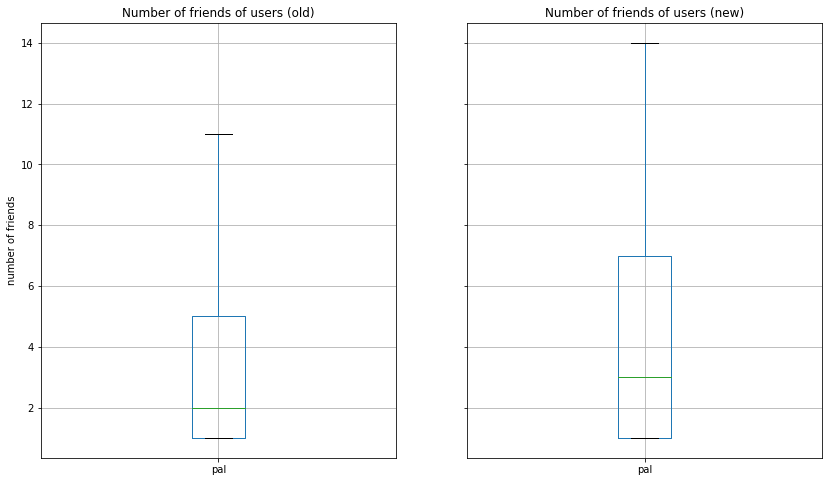

In [35]:
df_friend_old = pd.read_csv(friend_file.open('dataset_WWW2019/dataset_WWW_friendship_old.txt'), header = None, sep = "\t", names = ["friend", "pal"])
fig, ax = plt.subplots(1,2, figsize = (14, 8), sharey = True)
ax[0].set_title("Number of friends of users (old)")
ax[1].set_title("Number of friends of users (new)")
ax[0].set_ylabel("number of friends")
df_friend_old.groupby("friend").count().boxplot(ax = ax[0], column = ['pal'],showfliers=False)
df_friend.groupby("friend").count().boxplot(ax = ax[1], column = ['pal'],showfliers=False)

The results indicate us that most users don't have many friends on Foursquare. There are a few "super users" that have a lot of friends and they falsify our average values. If we want to find meaningful results, we should work on the quartiles.<br>
We notice that the number seems to have grown over time, but not by a lot.

### Step 2 : Behaving like natives

Now that we have an idea of how sociable natives are, we need to identify how they behave. In order to do so, we must identify the places they go to, at what frequency, and what combinations of places they go on the same day.<br>
The graph below gives us some information on activities that natives do, but we don't know much about the context. Imagine for example that everybody goes shopping on the week-end : what a major "faux-pas" it would be to go on weekdays after work ! What if you want to hang out ? What combination of activities should you choose ? So many questions...

In [69]:
# We recall the results we had last time. We need to identify if this behavior is representative of the whole
# population or if this is particular to a subset of individuals.
df_US_natives.groupby(by = "building").agg("count").sort_values(by = "person_id", ascending = False).head(10)

,zone_id,person_id,time_checkin,year,Lat,lon,country,day_of_check_in
building,,,,,,,,
Home (private),56962,56962,56962,56962,56962,56962,56962,56962
Office,45859,45859,45859,45859,45859,45859,45859,45859
Coffee Shop,41529,41529,41529,41529,41529,41529,41529,41529
Airport,38303,38303,38303,38303,38303,38303,38303,38303
Gym,33411,33411,33411,33411,33411,33411,33411,33411
American Restaurant,31235,31235,31235,31235,31235,31235,31235,31235
Bar,28422,28422,28422,28422,28422,28422,28422,28422
Grocery Store,27379,27379,27379,27379,27379,27379,27379,27379
Building,20495,20495,20495,20495,20495,20495,20495,20495


In [171]:
# We start by creating a column indicating the day of the checkin

df_US_natives["day_of_check_in"] = df_US_natives["time_checkin"].apply(lambda x : x[:10])

# We start by looking at how many checkins each user does daily. From this, we extract the list of users and 
# that checked-in more than once per day and the dataframe of their checkins.
multi_day_dataset = df_US_natives.groupby(["person_id", "day_of_check_in"]).agg("count").sort_values(by = "zone_id", ascending = False)
list_of_multi_day = multi_day_dataset[multi_day_dataset["zone_id"]>1].index.to_list()
dataframe_multi_day = df_US_natives.set_index(["person_id", "day_of_check_in"]).loc[list_of_multi_day].drop(columns = ["year", "zone_id","Lat", "lon", "country"])

/home/truc/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [172]:
# A first interesting observation is that most checkins come from people that checked more than once per day.
# We can interpret this as : a minority of users are responsible for the majority of the checkins.
dataframe_multi_day.shape[0]/df_US_natives.shape[0]

0.5514658826008847

In [173]:
dataframe_multi_day

time_checkin              building
person_id day_of_check_in                                                 
347405    2013-01-12       2013-01-12 05:49:08+00:00            University
          2013-01-12       2013-01-12 07:40:27+00:00            University
          2013-01-12       2013-01-12 08:17:48+00:00            University
          2013-01-12       2013-01-12 09:25:48+00:00        Student Center
          2013-01-12       2013-01-12 09:26:03+00:00        Student Center
...                                              ...                   ...
22638     2013-12-13       2013-12-13 00:33:51+00:00    Basketball Stadium
22660     2013-02-25       2013-02-25 03:01:53+00:00               Airport
          2013-02-25       2013-02-25 04:17:11+00:00           Event Space
46607     2013-09-04       2013-09-04 12:26:17+00:00  Gas Station / Garage
          2013-09-04       2013-09-04 13:08:53+00:00   Rental Car Location

[643698 rows x 2 columns]

In [174]:
# There are some people who check multiple times a day to the same place. We interpret this as them checking-in 
# On their workplace or at their home. This does not interest us. As a result, we eliminate users who check-in
# only at the same place.

count_nb_checkin_per_day = dataframe_multi_day.groupby(by = ["person_id", "day_of_check_in", "building"]).agg("count").reset_index()
inter = count_nb_checkin_per_day.groupby(by = ["person_id", "day_of_check_in"]).agg("count")
inter_list = inter[inter["building"]>1].index.to_list()
people_who_checked_at_multiple_places = count_nb_checkin_per_day.set_index(["person_id", "day_of_check_in"]).loc[inter_list].reset_index()
merged_db = people_who_checked_at_multiple_places.merge(people_who_checked_at_multiple_places, on = ["person_id", "day_of_check_in"])
merged_db = merged_db[merged_db["building_x"] != merged_db["building_y"]].drop(columns = ["time_checkin_x"])

In [176]:
# We now put on a label indicating the two activities that are done at the same time. The label is : 
# (activity_1, activity_2). Since (activity_1, activity_2) = (activity_2, activity_1), we have each row repeated 
# twice. We will take care of this later.
inter = pd.DataFrame()
inter["first_building"] = merged_db["building_x"]
inter["second_building"] = merged_db["building_y"]
inter_list = inter.values.tolist()
merged_db["label"] = [tuple(sorted(list(val))) for val in inter_list]

In [168]:
merged_db

,person_id,day_of_check_in,building_x,building_y,time_checkin_y,label
1,19,2013-01-05,Airport,Tech Startup,1,"(Airport, Tech Startup)"
2,19,2013-01-05,Tech Startup,Airport,1,"(Airport, Tech Startup)"
5,19,2013-01-09,Coffee Shop,University,1,"(Coffee Shop, University)"
6,19,2013-01-09,University,Coffee Shop,1,"(Coffee Shop, University)"
9,19,2013-01-11,Bar,Italian Restaurant,1,"(Bar, Italian Restaurant)"
...,...,...,...,...,...,...
1864297,2181131,2013-04-24,Residential Building (Apartment / Condo),Home (private),1,"(Home (private), Residential Building (Apartme..."
1864300,2181131,2013-04-25,Building,Residential Building (Apartment / Condo),1,"(Building, Residential Building (Apartment / C..."
1864301,2181131,2013-04-25,Residential Building (Apartment / Condo),Building,1,"(Building, Residential Building (Apartment / C..."
1864304,2181131,2013-04-29,Building,Home (private),1,"(Building, Home (private))"


In [179]:
# Now, we want to evaluate the occurence of each label, we also divide our values by 2 in order to compensate
# the fact that (activity_1, activity_2) = (activity_2, activity_1)
db_ordered_by_labels = merged_db.groupby("label").agg("count").sort_values(by = "person_id", ascending = False).drop(columns = ["day_of_check_in","building_x", "building_y", "time_checkin_y" ])
db_ordered_by_labels["person_id"] = db_ordered_by_labels["person_id"]/2

<BarContainer object of 20 artists>

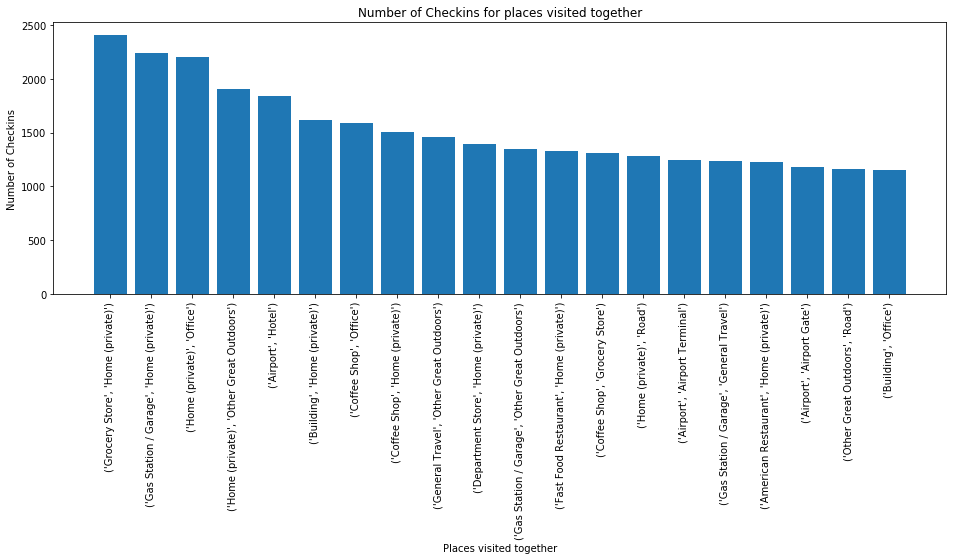

In [197]:
fig, ax = plt.subplots(figsize=(16,5))

plt.title('Number of Checkins for places visited together')
plt.ylabel('Number of Checkins')
plt.xlabel('Places visited together')
plt.xticks(rotation=90)

my_index = [str(element) for element in db_ordered_by_labels.head(20).index]
my_values = [element[0] for element in db_ordered_by_labels.head(20).values]
plt.bar(my_index, my_values)